In [87]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
args = {}
args['dim_h'] = 32            # factor controlling size of hidden layers
args['n_channel'] = 1         # number of channels in the input data (MNIST is 1, aka greyscale)
args['n_z'] = 10              # number of dimensions in latent space. -- might need to bump this up? not sure what's common for MNIST
args['sigma'] = 1.0           # variance in n_z
args['lambda'] = 10           # hyper param for weight of discriminator loss
args['lr'] = 0.0002           # learning rate for Adam optimizer
args['epochs'] = 10           # how many epochs to run for
args['batch_size'] = 256      # batch size for SGD

In [79]:
## load MNIST data train and test sets
trainset = datasets.MNIST(
    root='./data/',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

testset = datasets.MNIST(
    root='./data/',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

train_loader = DataLoader(
    dataset=trainset,
    batch_size=args['batch_size'],
    shuffle=True
)

test_loader = DataLoader(
    dataset=testset,
    batch_size=args['batch_size'],
    shuffle=False
)

## Try out the vanilla autoencoder 

In [80]:
## create encoder model and decoder model
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze()
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU()
        )

        # deconvolutional filters, essentially the inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x

In [81]:
# instantiate models, and set to train mode
encoder, decoder = Encoder(args), Decoder(args)
encoder.train()
decoder.train()

# specify loss (mean squared error of image reconstruction)
criterion = nn.MSELoss()

# use the Adam optimizer, it's always a good choice
enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])

enc_scheduler = StepLR(enc_optim, step_size=30, gamma=0.5)
dec_scheduler = StepLR(dec_optim, step_size=30, gamma=0.5)

In [82]:
for epoch in range(args['epochs']):
    step = 0

    for images, _ in tqdm(train_loader):
        encoder.zero_grad()
        decoder.zero_grad()
        batch_size = images.size()[0]

        z_real = encoder(images)
        x_recon = decoder(z_real)
        recon_loss = criterion(x_recon, images)

        recon_loss.backward()
        
        enc_optim.step()
        dec_optim.step()
        
        step += 1

    print("Epoch: [%d/%d], Step: [%d/%d], Reconstruction Loss: %.4f" %
          (epoch + 1, args['epochs'], step + 1, len(train_loader), recon_loss.data.item()))            


 66%|██████▌   | 155/235 [02:03<01:03,  1.25it/s]


100%|██████████| 235/235 [03:15<00:00,  1.21it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [1/10], Step: [236/235], Reconstruction Loss: 0.0486



 66%|██████▋   | 156/235 [02:17<01:46,  1.35s/it]


100%|██████████| 235/235 [03:29<00:00,  1.22it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [2/10], Step: [236/235], Reconstruction Loss: 0.0336



 66%|██████▋   | 156/235 [02:15<01:10,  1.12it/s]


100%|██████████| 235/235 [03:20<00:00,  1.28it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [3/10], Step: [236/235], Reconstruction Loss: 0.0272



 66%|██████▋   | 156/235 [02:27<01:10,  1.12it/s]


100%|██████████| 235/235 [03:44<00:00,  1.37it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [4/10], Step: [236/235], Reconstruction Loss: 0.0200



 66%|██████▋   | 156/235 [02:05<01:08,  1.15it/s]


100%|██████████| 235/235 [03:20<00:00,  1.12it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [5/10], Step: [236/235], Reconstruction Loss: 0.0159



 66%|██████▋   | 156/235 [02:12<01:01,  1.28it/s]


100%|██████████| 235/235 [03:18<00:00,  1.25it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [6/10], Step: [236/235], Reconstruction Loss: 0.0141



 66%|██████▋   | 156/235 [02:15<01:00,  1.32it/s]


100%|██████████| 235/235 [03:21<00:00,  1.62it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [7/10], Step: [236/235], Reconstruction Loss: 0.0138



 66%|██████▋   | 156/235 [02:01<00:56,  1.39it/s]


100%|██████████| 235/235 [03:04<00:00,  1.40it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [8/10], Step: [236/235], Reconstruction Loss: 0.0150



 66%|██████▋   | 156/235 [02:19<01:04,  1.22it/s]


100%|██████████| 235/235 [03:34<00:00,  1.43it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [9/10], Step: [236/235], Reconstruction Loss: 0.0120



 66%|██████▋   | 156/235 [02:07<01:07,  1.17it/s]


100%|██████████| 235/235 [03:07<00:00,  1.65it/s]


Epoch: [10/10], Step: [236/235], Reconstruction Loss: 0.0158


## Let's look at some images

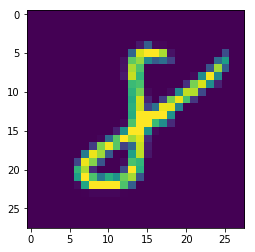

In [84]:
# look at an original image
plt.imshow(images[2,0].numpy())

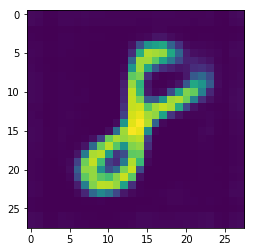

In [85]:
# run same image through autoencoder and take a peak
z_reps = encoder(images)
decoded_images = decoder(z_reps)

plt.imshow(decoded_images[2,0].detach().numpy())

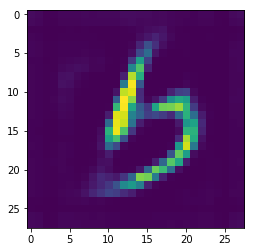

In [86]:
# try a random sample of the latent space
rand_z_reps = torch.randn_like(z_reps)
rand_decoded_images = decoder(rand_z_reps)

plt.imshow(rand_decoded_images[2,0].detach().numpy())

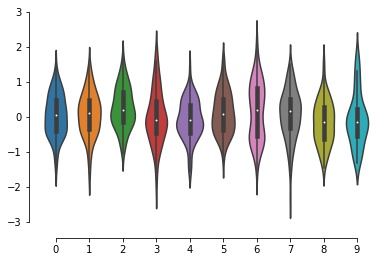

In [88]:
# another way to view the latent distribution -- not necessarily more informative, but..
data = pd.DataFrame(z_reps.detach().numpy())
sns.violinplot(data=data)
sns.despine(offset=10, trim=True);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f37bb605f28>,
      dtype=object)

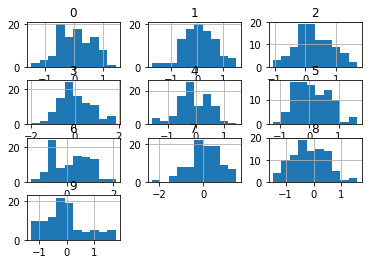

In [89]:
pd.DataFrame(z_reps.detach().numpy()).hist()

## WAE-GAN!

In [90]:
# define the descriminator
class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()

        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # main body of discriminator, returns [0,1]
        self.main = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x
    
# control which parameters are frozen / free for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False

In [91]:
# instantiate discriminator model, and restart encoder and decoder, for fairness. Set to train mode, etc
encoder, decoder, discriminator = Encoder(args), Decoder(args), Discriminator(args)
encoder.train()
decoder.train()
discriminator.train()

enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])
dis_optim = torch.optim.Adam(discriminator.parameters(), lr = args['lr'])

enc_scheduler = StepLR(enc_optim, step_size=30, gamma=0.5)
dec_scheduler = StepLR(dec_optim, step_size=30, gamma=0.5)
dis_scheduler = StepLR(dis_optim, step_size=30, gamma=0.5)

In [92]:
one = torch.Tensor([1])

for epoch in range(args['epochs']):
    step = 0

    for images, _ in tqdm(train_loader):
        encoder.zero_grad()
        decoder.zero_grad()
        discriminator.zero_grad()

        # ======== Train Discriminator ======== #
        
        # freeze auto encoder params
        frozen_params(decoder)
        frozen_params(encoder)
        
        # free discriminator params
        free_params(discriminator)

        # run discriminator against randn draws
        z_fake = torch.randn(images.size()[0], args['n_z']) * args['sigma']
        d_fake = discriminator(z_fake)

        # run discriminator against encoder z's
        z_real = encoder(images)
        d_real = discriminator(z_real)

        # formula for ascending the descriminator -- -one reverses the direction of the gradient.
        torch.log(d_fake).mean().backward(-one)
        torch.log(1 - d_real).mean().backward(-one)

        dis_optim.step()

        # ======== Train Generator ======== #

        # flip whose frozen, whose not
        free_params(decoder)
        free_params(encoder)
        frozen_params(discriminator)

        batch_size = images.size()[0]

        # run images
        z_real = encoder(images)
        x_recon = decoder(z_real)
        
        # discriminate latents
        d_real = discriminator(encoder(images.data))

        # calculate reconstruction loss
        recon_loss = criterion(x_recon, images)
        
        # calculate discriminator loss
        d_loss = args['lambda'] * (torch.log(d_real)).mean()

        recon_loss.backward(one)
        d_loss.backward(-one)

        enc_optim.step()
        dec_optim.step()

        step += 1

    # print stats after each epoch
    print("Epoch: [{}/{}], Step: [{}/{}], Reconstruction Loss: {}, d_loss: {}".format(
        epoch + 1, 
        args['epochs'], 
        step + 1, 
        len(train_loader), 
        recon_loss.data.item(),
        d_loss.data.item()
    ))


 66%|██████▌   | 155/235 [02:43<01:17,  1.03it/s]


100%|██████████| 235/235 [04:05<00:00,  1.13s/it]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [1/10], Step: [236/235], Reconstruction Loss: 0.060842350125312805, d_loss: -7.173596382141113



 66%|██████▋   | 156/235 [02:27<01:10,  1.12it/s]


100%|██████████| 235/235 [03:55<00:00,  1.03s/it]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [2/10], Step: [236/235], Reconstruction Loss: 0.04999901354312897, d_loss: -7.405599594116211



 66%|██████▋   | 156/235 [02:37<01:22,  1.05s/it]


100%|██████████| 235/235 [04:03<00:00,  1.09it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [3/10], Step: [236/235], Reconstruction Loss: 0.04910823702812195, d_loss: -7.230966567993164



 66%|██████▋   | 156/235 [02:54<01:13,  1.07it/s]


100%|██████████| 235/235 [04:16<00:00,  1.32it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [4/10], Step: [236/235], Reconstruction Loss: 0.04699758440256119, d_loss: -6.974987983703613



 41%|████      | 96/235 [01:48<02:34,  1.11s/it]

KeyboardInterrupt: 

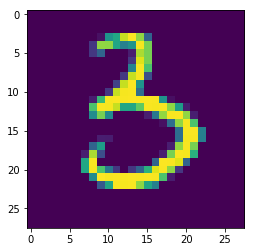

In [93]:
# look at an original image
plt.imshow(images[0,0].numpy())

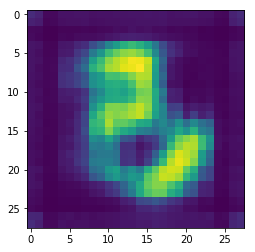

In [94]:
# run same image through autoencoder and take a peak
z_reps = encoder(images)
decoded_images = decoder(z_reps)

plt.imshow(decoded_images[0,0].detach().numpy())

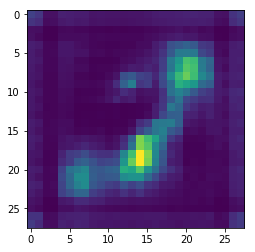

In [95]:
# try a random sample of the latent space
rand_z_reps = torch.randn_like(z_reps)
rand_decoded_images = decoder(rand_z_reps)

plt.imshow(rand_decoded_images[0,0].detach().numpy())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f37bb0dd940>,
      dtype=object)

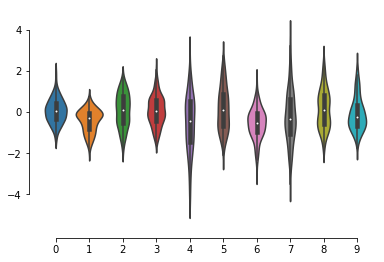

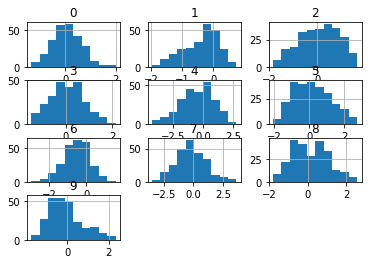

In [96]:
data = pd.DataFrame(z_reps.detach().numpy())
sns.violinplot(data=data)
sns.despine(offset=10, trim=True);
pd.DataFrame(z_reps.detach().numpy()).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f37bae6ce48>,
      dtype=object)

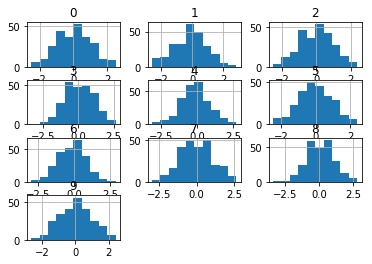

In [97]:
fake_z_reps = torch.randn_like(z_reps)
pd.DataFrame(fake_z_reps.numpy()).hist()